## Power law fit to the Rsp/R200m-Gamma relation of halos

Perform fits to $R_{\rm sp}$, $R_{200m}$, and $\Gamma$ from Benedikt's simulations, where $R_{\rm sp}$ is estimated from the splashback shells identified using <tt>Shellfish</tt> algorithm.

In [1]:
# setup notebook for inline figures
%matplotlib inline

import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt

plt.rc("savefig",dpi=175)
plt.rc('text', usetex=True)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)


In [2]:
# import Benedikt Diemer's colossus package
from colossus.cosmology import cosmology
# set cosmology to the best values from 9-year WMAP data

params = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.0469, 'sigma8': 0.82, 'ns': 0.95}
cosmology.addCosmology('myCosmo', params)
cosmo = cosmology.setCosmology('myCosmo')

print cosmo.Om(z=2.0)

0.908204102025


In [3]:
def MCMCsample(x, nparams=2, nwalkers=100, nRval=100, modelpdf = None, ipar_active = None, params=[], Rlim = 1.01):
    """
    MCMC sampler implementing the Goodman & Weare (2010) affine-invariant algorithm
    inner loop is vectorized
    
    written by Andrey Kravtsov (2014-2016)
    """
    
    try:
        import acor
    except:
        raise Exception("acor package is not installed!")
        
    # parameters used to draw random number with the GW10 proposal distribution
    ap = 2.0; api = 1.0/ap; asqri=1.0/np.sqrt(ap); afact=(ap-1.0)

    # calculate effective number of parameters if some are specified to be fixed
    ia = (ipar_active==1)
    npareff = np.size(ipar_active[ia])
    print "starting sampling with %d active parameters of the total %d parameters"%(npareff, nparams)
    
    # initialize some auxiliary arrays and variables 
    chain = []; Rval = []

    naccept = 0; ntry = 0; nchain = 0
    mw = np.zeros((nwalkers,npareff)); sw = np.zeros((nwalkers,npareff))
    m = np.zeros(npareff); Wgr = np.zeros(npareff); Bgr = np.zeros(npareff); Rgr = np.zeros(npareff)
    
    mutx = []; taux = []
    for i in range(npareff): 
        mutx.append([]); taux.append([])
        Rval.append([])

    gxo = np.zeros((2,nwalkers/2))
    gxo[0,:] = modelpdf(x[0,:,:], params); gxo[1,:] = modelpdf(x[1,:,:], params)
    converged = False;
    while not converged:
        # for parallelization (not implemented here but the MPI version is available)
        # the walkers are split into two complementary sub-groups (see GW10)
        for kd in range(2):
            k = abs(kd-1)
            # vectorized inner loop of walkers stretch move in the Goodman & Weare sampling algorithm
            xchunk = x[k,:,:]
            jcompl = np.random.randint(0,nwalkers/2,nwalkers/2)
            xcompl = x[kd,jcompl,:]
            gxold  = gxo[k,:]
            zf= np.random.rand(nwalkers/2)   # the next few steps implement Goodman & Weare sampling algorithm
            zf = zf * afact; zr = (1.0+zf)*(1.0+zf)*api
            zrtile = np.transpose(np.tile(zr,(nparams,1))) # duplicate zr for nparams
            xtry  = xcompl + zrtile*(xchunk-xcompl)
            gxtry = modelpdf(xtry, params); gx    = gxold 
            gr   = gxtry - gx
            iacc = np.where(gr>0.)
            xchunk[iacc] = xtry[iacc]
            gxold[iacc] = gxtry[iacc]
            aprob = (npareff-1)*np.log(zr) + (gxtry - gx)
            u = np.random.uniform(0.0,1.0,np.shape(xchunk)[0])        
            iprob = np.where(aprob>np.log(u))
            xchunk[iprob] = xtry[iprob]
            gxold[iprob] = gxtry[iprob]
            naccept += len(iprob[0])

            x[k,:,ia] = np.transpose(xchunk[:,ia])
            gxo[k,:] = gxold        
            xdum = x[:,:,ia]

            for i in range(nwalkers/2):
                chain.append(np.array(xdum[k,i,:]))

            for i in range(nwalkers/2):
                mw[k*nwalkers/2+i,:] += xdum[k,i,:]
                sw[k*nwalkers/2+i,:] += xdum[k,i,:]**2
                ntry += 1

        nchain += 1
        
        # compute means for the auto-correlation time estimate
        for i in range(npareff):
            mutx[i].append(np.sum(xdum[:,:,i])/(nwalkers))

        # compute Gelman-Rubin indicator for all parameters
        if ( nchain >= nwalkers/2 and nchain%nRval == 0):
            # calculate Gelman & Rubin convergence indicator
            mwc = mw/(nchain-1.0)
            swc = sw/(nchain-1.0)-np.power(mwc,2)

            for i in range(npareff):
                # within chain variance
                Wgr[i] = np.sum(swc[:,i])/nwalkers
                # mean of the means over Nwalkers
                m[i] = np.sum(mwc[:,i])/nwalkers
                # between chain variance
                Bgr[i] = nchain*np.sum(np.power(mwc[:,i]-m[i],2))/(nwalkers-1.0)
                # Gelman-Rubin R factor
                Rgr[i] = (1.0 - 1.0/nchain + Bgr[i]/Wgr[i]/nchain)*(nwalkers+1.0)/nwalkers - (nchain-1.0)/(nchain*nwalkers)
                tacorx = acor.acor(mutx[i])[0]; taux[i].append(np.max(tacorx))
                Rval[i].append(Rgr[i]-1.0)
            print "nchain=",nchain
            print "R values for parameters:", Rgr
            print "tcorr =", np.max(tacorx)
            if np.max(np.abs(Rgr-1.0)) < np.abs(Rlim-1.0): converged = True
        
    print "MCMC sampler generated ",ntry," samples using", nwalkers," walkers"
    print "with step acceptance ratio of", 1.0*naccept/ntry
        
    # record integer auto-correlation time at the final iteration
    nthin = int(tacorx)

    return chain, Rval, nthin

def MCMCsample_init(nparams=2, nwalkers=100, x0=None, step=None, ipar_active=None):
    """
    distribute initial positions of walkers in an isotropic Gaussian around the initial point
    """
    np.random.seed()
    
    # in this implementation the walkers are split into 2 subgroups and thus nwalkers must be divisible by 2
    if nwalkers%2:
        raise ValueError("MCMCsample_init: nwalkers must be divisible by 2!")
         
    x = np.zeros([2,nwalkers/2,nparams])

    for i in range(nparams):
        x[:,:,i] = np.reshape(np.random.normal(x0[i],step[i],nwalkers),(2,nwalkers/2))
    ina = (ipar_active==0)
    if np.size(ina) > 0:
        x[:,:,ina] = x0[ina]
    return x


In [4]:
# likelihood for fitting the line to a set of points with the Gaussian scatter 
# and error bars in both variables (correlation between error bars 
# can be specified in covariance matrix elements c00, c01, c11
# derived from the original version by Surhud More (2011)

def prior(xd):
    """
    defines parameter priors
    """
    d0 = np.abs(xd[0]-4.0); p0 = 0.0
    d2 = xd[2]; p2 = 0.0
    d1 = np.abs(xd[1]); p1 = 0.0
    if d0 < 5.0 : p0 = 1.0
    if d1 < 5.0 : p1 = 1.0
    if (d2 >= 0.0) & (d2 < 0.5) : p2 = 1.0
    p = p0*p1*p2
    return 0. # ignore priors for these fits
#    if p > 0: 
#        return np.log(p)
#    else:
#        return -100.

def line_fit_vert_like (x, params=None): 
    """
    log likelihood for a linear model for data with error bars in both directions 
    and intrinsic scatter in y direction
    the merit function is also in y-direction (see d'Agostino 2005)
    input: x - vector of parameters: 
           x[0] = slope m; x[1] = intercept c; x[2]=intrinsic scatter
           params = [x, y, z, c00, c01, c11]            
    """
    p = params; nw = np.shape(x)[0]; res = np.zeros(nw) 
    Omd = cosmo.Om(p[2])
    for i in range(nw):
        mslope = x[i,0] + x[i,1]/Omd; cint = x[i,2] + x[i,3]*Omd 
        dummy = x[i,4] + p[5] + mslope**2*p[3]
        res[i] = -0.5*(np.sum(np.log(dummy))+np.sum((p[1]-mslope*p[0]-cint)**2/dummy)) + prior(x[i,:])
    return res


In [5]:
def mcmc_fit(x, y, z, ex, ey, pini=None, ipar_active=None, nwalkers=None, modelpdf=None, Rlim = 1.01, nRval = 1000):
    """
    input parameters: x, y, z     - 3 variable vectors to which the fit is made, 
                      ex, ey      - errors of x and y
                                    for this problem assume there could be errors in x (=Gamma) and y (Rsp/R200m), but not in z(=z)
                      pini        - vector of initial values of the parameters to be fitted
                      ipar_active - vector of the same length as pini
                                    indicating whether parameter is to be fitted (1) or kept fixed at initial value (0)
                      nwalkers    - number of walkers to be used in sampling, should be divisible by 2
                      modelpdf    - name of the function calculating log-likelihood
                      Rlim        - maximum value of the Gelman-Rubin indicator, 
                                    sampling will continue until this value is not reached for all fitted parameters
                      nRval       - frequency of output of Gelman-Rubin indicators, set to very large value if no output wanted
    """
    # covariance matrix of errors
    c00 = ex*ex; c01 = 0.; c11 = ey*ey
    p = pini; params = [x, y, z, c00, c01, c11]
    
    # define which parameters are active (=1), and which should stay fixed (=0)
    iactive = (ipar_active==1)
    nparams = np.size(ipar_active)

    x0 = np.array(p[0:nparams]); step = 0.1*np.array(np.abs(p[0:nparams]));
    iz = (step == 0); step[iz] = 0.0001 
    
    # initialize MCMC walkers
    xwalk = MCMCsample_init(nparams=nparams, nwalkers=nwalkers, x0=x0, step=step, ipar_active=ipar_active)
    
    # run the sampler
    # once finished, it will return the entire chain and how many values to thin based on the final auto-correlation time
    chain, Rval, nthin = MCMCsample(xwalk, nparams=nparams, nwalkers=nwalkers, nRval=nRval, 
                                    modelpdf=modelpdf, params=params, ipar_active=ipar_active, Rlim=Rlim)
    return chain, Rval, nthin


In [6]:
def sgolay2d ( z, window_size, order, derivative=None):
    """
    """
    from scipy.signal import fftconvolve
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0
    
    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')
    
    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2
    
    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]
    
    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])
        
    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band ) 
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z
    
    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band ) 
    
    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band ) 
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band ) 
    
    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return fftconvolve(Z, -c, mode='valid')        
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return fftconvolve(Z, -r, mode='valid')        
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return fftconvolve(Z, -r, mode='valid'), fftconvolve(Z, -c, mode='valid')        

In [7]:
import scipy.optimize as opt
from matplotlib.colors import LogNorm

def conf_interval(x, pdf, conf_level):
    return np.sum(pdf[pdf > x])-conf_level

def plot_2d_dist(x,y, xlim,ylim,nxbins,nybins, weights=None, xlabel='x',ylabel='y', clevs=None, smooth=None, fig_setup=None, savefig=None):
    if fig_setup == None:
        fig, ax = plt.subplots(figsize=(2.5, 2.5))
        #ax = plt.add_subplot(1,1,1)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.xlim(xlim[0], xlim[1])
        plt.ylim(ylim[0], ylim[1])
    else:
        ax = fig_setup
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xlim(xlim); ax.set_ylim(ylim)
    #
    if xlim[1] < 0.: ax.invert_xaxis()

    if weights == None: weights = np.ones_like(x)
    H, xbins, ybins = np.histogram2d(x, y, weights=weights, bins=(np.linspace(xlim[0], xlim[1], nxbins),np.linspace(ylim[0], ylim[1], nybins)))
    
    H = np.rot90(H); H = np.flipud(H); 
             
    X,Y = np.meshgrid(xbins,ybins) 
    if smooth != None:
        from scipy.signal import wiener
        H = wiener(H, mysize=3)
        H = sgolay2d( H, window_size=9, order=4)

    H = H/np.sum(H)        
    Hmask = np.ma.masked_where(H==0,H)
    
    pcol = ax.pcolormesh(X,Y,(Hmask), vmin=1.e-4*np.max(Hmask), cmap=plt.cm.BuPu, norm = LogNorm(), linewidth=0., rasterized=True)
    pcol.set_edgecolor('face')

    if clevs != None:
        lvls = []
        for cld in clevs:  
            sig = opt.brentq( conf_interval, 0., 1., args=(H,cld) )   
            lvls.append(sig)
                   
        ax.contour(H, linewidths=(1.0,0.75, 0.5, 0.25), colors='black', levels = lvls, 
                    norm = LogNorm(), extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]])
    if savefig:
        plt.savefig(savefig,bbox_inches='tight')
    if fig_setup == None:
        plt.show()
    return


In [8]:
# clever estimate of the Bayes factor from the AstroML library
# http://www.astroml.org/book_figures/chapter5/fig_model_comparison_mcmc.html#book-fig-chapter5-fig-model-comparison-mcmc
from sklearn.neighbors import BallTree
from scipy.special import gamma

def estimate_bayes_factor(traces, logp, r=0.05, return_list=False):
    """Estimate the bayes factor using the local density of points"""
    N, D = traces.shape
    
    # compute volume of a D-dimensional sphere of radius r
    Vr = np.pi**(0.5*D) / gamma(0.5*D + 1) * (r**D)

    # use neighbor count within r as a density estimator
    bt = BallTree(traces)
    count = bt.query_radius(traces, r=r, count_only=True)
    BF = logp + np.log(N) + np.log(Vr) - np.log(count)

    if return_list:
        return BF
    else:
        p25, p50, p75 = np.percentile(BF, [25, 50, 75])
        return p50, 0.7413 * (p75 - p25)


In [9]:
def pstats(x, imaxlike=None):
    xmed = np.median(x); xm = np.mean(x); xsd = np.std(x)
    xcfl11 = np.percentile(x,16); xcfl12 = np.percentile(x,84)
    xcfl21 = np.percentile(x,2.5); xcfl22 = np.percentile(x,97.5)

    print 'max. likelihood, mean, median = %.4f %.4f, %.4f, st.dev=%.4f'%(x[imaxlike], xm, xmed, xsd)
    print '68perc interval = %.3f, %.3f'%(xcfl11,xcfl12)
    print '95perc interval = %.3f, %.3f'%(xcfl21,xcfl22)
    print ' '
    return x[imaxlike], xm, xmed, xsd, xcfl11, xcfl12, xcfl21, xcfl22


In [10]:
# read in Phil's data and prepare it for fits

mrg_base = "data\mrg_L%s_z%s.dat"
rsp_base = "data\L%s_rsp_z%s.dat"

def read_int_ids(fname):
    """ Helper function. Neccessary to prevent truncation.
    """

    with open(fname)as fp: s = fp.read()
    lines = s.split("\n")
    col0s = [[tok for tok in line.split(" ") if tok!=""][0]
             for line in lines if line!=""]
    return np.array(map(int, col0s), dtype=int)

def load_box_data(L_str, z_str):
    """ load_box_data loads the R_sp, R_200m, and Gamma_200m data
    from the files conrresponding to a particular pair of L and z strings.
    """

    mrg_ids = read_int_ids(mrg_base % (L_str, z_str))
    order = np.argsort(mrg_ids)
    rsp_ids = read_int_ids(rsp_base % (L_str, z_str))
    mrg_idxs = np.searchsorted(mrg_ids[order], rsp_ids)

    r, g = np.loadtxt(mrg_base % (L_str, z_str),
                      usecols=(3, 4), unpack=True)
    r = r[order][mrg_idxs]
    g = g[order][mrg_idxs]
    rsp = np.loadtxt(rsp_base % (L_str, z_str), usecols=(3,))

    return rsp, r, g

L_strs = ["63", "125", "250", "500"]
z_strs = ["0", "05", "1", "2"]
zs = [0.0, 0.5, 1.0, 2.0]

iz = 0 
Rsp = np.array([]); R200m = np.array([]); G200 = np.array([]); zout = np.array([])
for iL, Ld in enumerate(L_strs):
    for iz, zsd in enumerate(z_strs):
        rspi, r200i, g200i = load_box_data(L_strs[iL], z_strs[iz])
        Rsp = np.hstack((Rsp,rspi)); R200m = np.hstack((R200m,r200i)); G200 = np.hstack((G200,g200i))
        zd = zs[iz]*np.ones_like(rspi); zout = np.hstack((zout,zd))
        
eRsp = 0.001*np.ones_like(Rsp); eG200 = 0.0001*np.ones_like(G200)

# pivot first
yd = Rsp/R200m; ey = eRsp; xd = G200; ex = eG200
# estimate of pivot
axp = np.sum(xd/ex**2.0)/np.sum(1./ex**2.0); ayp = np.sum(yd/ey**2.0)/np.sum(1./ey**2.0)
xp = xd - axp; yp = yd - ayp
print "axp=", axp, " ayp=", ayp

axp= 2.41131603142  ayp= 1.27541000061


C:\Users\h2_sf\AppData\Local\Enthought\Canopy\User\lib\site-packages\numpy\lib\npyio.py:823: UserWarning: loadtxt: Empty input file: "data\L500_rsp_z2.dat"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)


Initialize parameters and fit them.

In [11]:
nwalkers = 200

# m, c, sigma^2 [dex] - initial values
m0 = -0.033; m1 = -0.009; c0 = 1.35; c1 = 0.03; s2_0 = 0.2; # m, c, sigma^2 [dex] - initial values
ipar_active = np.array([1, 1, 1, 1, 1])

chain, Rval, nthin = mcmc_fit(xd, yd, zout, ex, ey, pini=[m0, m1, c0, c1, s2_0], 
                              ipar_active=ipar_active, nwalkers=nwalkers, modelpdf=line_fit_vert_like)



starting sampling with 5 active parameters of the total 5 parameters
nchain= 1000
R values for parameters: [ 1.03888494  1.03500749  0.99091881  1.01870841  1.00305543]
tcorr = 10.4077507305
nchain= 2000
R values for parameters: [ 1.01689911  1.01825824  0.99283104  1.0120932   1.00150067]
tcorr = 41.9511485484
nchain= 3000
R values for parameters: [ 1.01231184  1.01280083  0.99336195  1.01006806  1.00098734]
tcorr = 40.8178158035
nchain= 4000
R values for parameters: [ 1.00880243  1.00935792  0.9932631   1.00734287  1.00074722]
tcorr = 39.4591748315
MCMC sampler generated  800000  samples using 200  walkers
with step acceptance ratio of 0.4597325


C:\Users\h2_sf\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:37: RuntimeWarning: invalid value encountered in log
C:\Users\h2_sf\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:53: RuntimeWarning: invalid value encountered in greater
C:\Users\h2_sf\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:58: RuntimeWarning: invalid value encountered in greater


In [12]:
# number of burn-in sample following Sokal's suggestion
nburn = int(20*nwalkers*nthin)
# extract parameters from the chain
m0d = zip(*chain)[0]; m1d = zip(*chain)[1]; c0d = zip(*chain)[2]; c1d = zip(*chain)[3]
sd = zip(*chain)[4];
xch = np.zeros([np.size(sd[nburn:]),5])

xch[:,0] = m0d[nburn:]; xch[:,1] = m1d[nburn:]; xch[:,2] = c0d[nburn:]; xch[:,3] = c1d[nburn:]; xch[:,4] = sd[nburn:]


In [13]:
c00 = ex*ex; c01 = 0.0; c11 = ey*ey
params = [xd, yd, zout, c00, c01, c11]

loglikevals = line_fit_vert_like(xch, params)

imaxlike = np.argmax(loglikevals)
print imaxlike, np.size(loglikevals)

248401 644000


In [42]:

print "============ best parameters of the full 5-parameter fit of Phil's function =================="
print "best fit slope 1:"
m0_lmax, m0_med, m0_mean, m0_std, m0_68m, m0_68p, m0_95m, m0_95p = pstats(m0d, imaxlike)
print "best fit slope 2:"
m1_lmax, m1_med, m1_mean, m1_std, m1_68m, m1_68p, m1_95, m1_95p = pstats(m1d, imaxlike)
print "best fit intercept a, pivoted to %.4f:"%ayp
c0_lmax, c0_med, c0_mean, c0_std, c0_68m, c0_68p, c0_95m, c0_95p = pstats(c0d, imaxlike)
print "best fit intercept A:"
c1_lmax, c1_med, c1_mean, c1_std, c1_68m, c1_68p, c1_95m, c1_95p = pstats(c1d, imaxlike)
print "best fit scatter:",
s_lmax, s_med, s_mean, s_std, s_68m, s_68p, s_95m, s_95p = pstats(np.sqrt(sd), imaxlike)

bic = -2.*loglikevals[imaxlike] + 5.*np.log(np.size(xp))
print "BIC factor of the fit = %.3e"%bic


============ best parameters of the full 5-parameter fit of Phil's function ==================
best fit slope 1:
max. likelihood, mean, median = -0.0369 -0.0327, -0.0327, st.dev=0.0037
68perc interval = -0.036, -0.029
95perc interval = -0.040, -0.026
 
best fit slope 2:
max. likelihood, mean, median = -0.0068 -0.0096, -0.0096, st.dev=0.0018
68perc interval = -0.011, -0.008
95perc interval = -0.013, -0.006
 
best fit intercept a, pivoted to 1.2754:
max. likelihood, mean, median = 1.3293 1.3434, 1.3428, st.dev=0.0150
68perc interval = 1.331, 1.355
95perc interval = 1.319, 1.370
 
best fit intercept A:
max. likelihood, mean, median = 0.1151 0.0937, 0.0946, st.dev=0.0208
68perc interval = 0.075, 0.113
95perc interval = 0.046, 0.133
 
best fit scatter: max. likelihood, mean, median = 0.1462 0.1463, 0.1443, st.dev=0.0207
68perc interval = 0.143, 0.146
95perc interval = 0.141, 0.149
 
BIC factor of the fit = -9.543e+03


In [15]:
bf, ebf = estimate_bayes_factor(xch, loglikevals, r=0.05)

print "Bayes factor=:", bf, ebf

Bayes factor=: 4790.235495 1.46412731167


Let's plot results.

C:\Users\h2_sf\AppData\Local\Enthought\Canopy\User\lib\site-packages\matplotlib\contour.py:1516: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


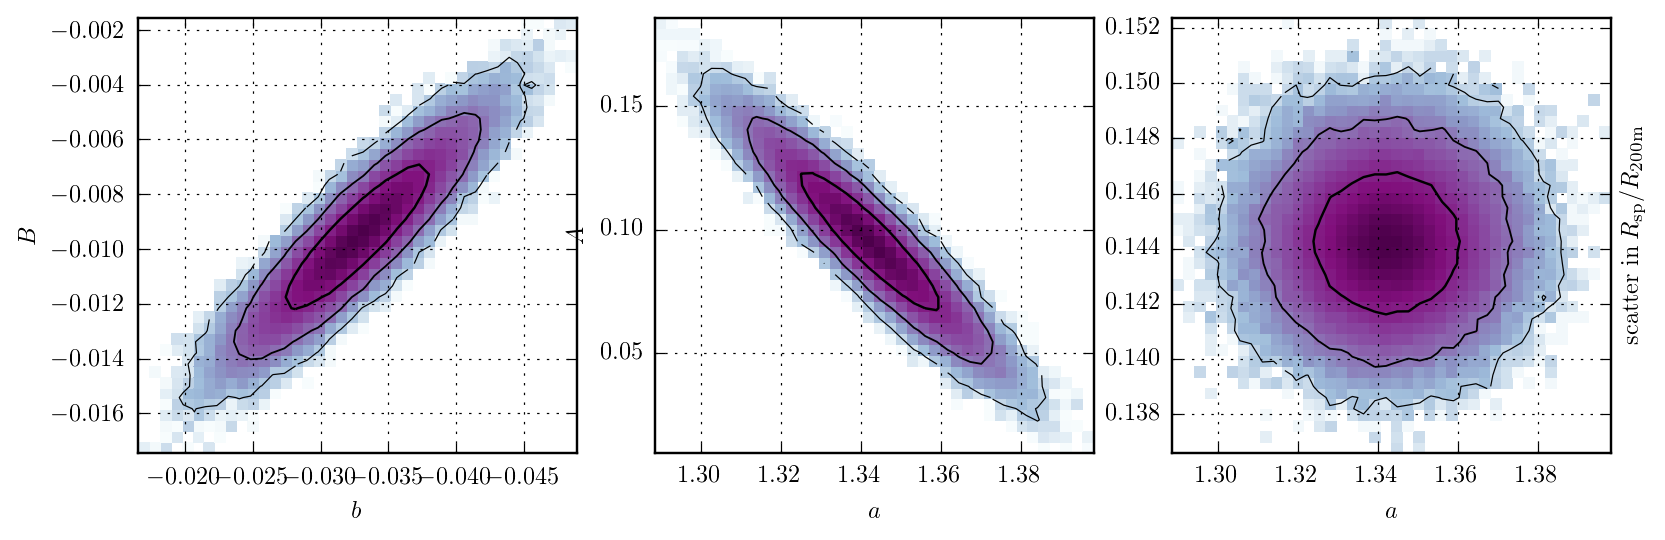

In [16]:

m0lim = [np.min(xch[:,0]), np.max(xch[:,0])]; m1lim = [np.min(xch[:,1]), np.max(xch[:,1])]
c0lim = [np.min(xch[:,2]), np.max(xch[:,2])]; c1lim = [np.min(xch[:,3]), np.max(xch[:,3])]; 
sc = np.sqrt(xch[:,4])
slim = [np.min(sc), np.max(sc)]
clevs = (0.683, 0.955, 0.997) #np.linspace(0.2,0.95,4)

# let's plot 2d posterios of the parameters
fig, ax = plt.subplots(1,3,figsize=(9.,3.))
plt.tight_layout(); plt.rc('font',size=10)

plot_2d_dist(xch[:,0], xch[:,1], xlim=m0lim, ylim=m1lim, nxbins=41, nybins=41, clevs=clevs, 
             xlabel=r'$b$', ylabel=r'$B$',  fig_setup=ax[0])
ax[0].grid()
plot_2d_dist(xch[:,2], xch[:,3], xlim=c0lim, ylim=c1lim, nxbins=41, nybins=41, clevs=clevs, 
             xlabel=r'$a$', ylabel=r'$A$',  fig_setup=ax[1])
ax[1].grid()
plot_2d_dist(xch[:,2], sc, xlim=c0lim, ylim=slim, nxbins=41, nybins=41, clevs=clevs, 
             xlabel=r'$a$', ylabel=r'$\mathrm{scatter\ in\ }R_{\rm sp}/R_{\rm 200m}$',  fig_setup=ax[2])
ax[2].yaxis.set_label_position('right')
ax[2].grid()
plt.show()


We can see that the best fit numbers for slope, intercept, and scatter are pretty close to Phil's. However, there are a couple of important differences: 1) error on scatter is much larger, 2) parameters a and A and b and B are quite degenerate, so separate errors on these parameters are meaningless without covariance. 2 and 3 indicate that there are too many parameters in the fit: there is no strong need for redshift dependence of the slope in the data and the intercept could be just modelled by a single parameter. This will be tried below. 

### a simpler parametrization with only 4 parameters (slope independent of redshift).

In [17]:
def line_fit_vert_like2 (x, params=None): 
    """
    log likelihood for a linear model for data with error bars in both directions 
    and intrinsic scatter in y direction
    the merit function is also in y-direction (see d'Agostino 2005)
    input: x - vector of parameters: 
           x[0] = slope m; x[1] = intercept c0; x[2] = intercept c1*Omega(z); x[3]=intrinsic scatter
           params = [x, y, z, c00, c01, c11]            
    """
    p = params; nw = np.shape(x)[0]; res = np.zeros(nw) 
    Omd = cosmo.Om(p[2])
    for i in range(nw):
        mslope = x[i,0]; cint = x[i,1] + x[i,2]*Omd 
        dummy = x[i,3] + p[5] + mslope**2*p[3]
        res[i] = -0.5*(np.sum(np.log(dummy))+np.sum((p[1]-mslope*p[0]-cint)**2/dummy)) + prior(x[i,:])
    return res


In [18]:
# m, c, sigma^2 [dex] - initial values
m0=0.0; c0=0.1; c1 = 0.05; s2_0 = 0.02; 
ipar_active = np.array([1, 1, 1, 1])

chain, Rval, nthin = mcmc_fit(xd, yd, zout, ex, ey, pini=[m0, c0, c1,  s2_0], 
                              ipar_active=ipar_active, nwalkers=nwalkers, 
                              modelpdf=line_fit_vert_like2)



starting sampling with 4 active parameters of the total 4 parameters
nchain= 1000
R values for parameters: [ 1.0033404   1.00460649  1.02504265  1.01445111]
tcorr = 15.502905152
nchain= 2000
R values for parameters: [ 1.0016745   1.00225505  1.01196349  1.00702663]
tcorr = 15.8752798094
nchain= 3000
R values for parameters: [ 1.00134112  1.00149547  1.00786975  1.00463594]
tcorr = 15.5362885668
MCMC sampler generated  600000  samples using 200  walkers
with step acceptance ratio of 0.496391666667


C:\Users\h2_sf\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: invalid value encountered in log
C:\Users\h2_sf\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:53: RuntimeWarning: invalid value encountered in greater
C:\Users\h2_sf\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:58: RuntimeWarning: invalid value encountered in greater


In [19]:
nburn = int(20*nwalkers*nthin)

m = zip(*chain)[0]; c0 = zip(*chain)[1]; c1 = zip(*chain)[2]; s = np.sqrt(zip(*chain)[3])
m = m[nburn:]; c0 = c0[nburn:]; c1 = c1[nburn:]; s = s[nburn:]


In [20]:
c00 = ex*ex; c01 = 0.0; c11 = ey*ey
params = [xd, yd, zout, c00, c01, c11]

xch = np.zeros([np.size(m),4])
xch[:,0] = m; xch[:,1] = c0; xch[:,2] = c1; xch[:,3] = s*s
loglikevals2 = line_fit_vert_like2(xch, params)

imaxlike2 = np.argmax(loglikevals2)
print imaxlike2, np.size(loglikevals2)

76055 540000


In [21]:

print "============ best parameters of the fit with slope independent of z =================="
print "best fit slope:"
m_lmax2, m_med2, m_mean2, m_std2, m_68m2, m_68p2, m_95m, m_95p = pstats(m, imaxlike2)
print "best fit intercept a, pivoted to %.4f:"%ayp
c0_lmax2, c0_med2, c0_mean2, c0_std2, c0_68m2, c0_68p2, c0_95m, c0_95p = pstats(c0, imaxlike2)
print "best fit intercept A:"
c1_lmax2, c1_med2, c1_mean2, c1_std2, c1_68m2, c1_68p2, c1_95m, c1_95p = pstats(c1, imaxlike2)
print "best fit scatter:",
s_lmax2, s_med2, s_mean2, s_std2, s_68m2, s_68p2, s_95m, s_95p = pstats(s, imaxlike2)

bic2 = -2.*loglikevals2[imaxlike2] + 4.*np.log(np.size(xp))
print "BIC factor of the fit = %.3e"%bic2


============ best parameters of the fit with slope independent of z ==================
best fit slope:
max. likelihood, mean, median = -0.0498 -0.0498, -0.0498, st.dev=0.0016
68perc interval = -0.051, -0.048
95perc interval = -0.053, -0.047
 
best fit intercept a, pivoted to 1.2754:
max. likelihood, mean, median = 1.2887 1.2889, 1.2889, st.dev=0.0069
68perc interval = 1.282, 1.296
95perc interval = 1.275, 1.303
 
best fit intercept A:
max. likelihood, mean, median = 0.1822 0.1820, 0.1820, st.dev=0.0108
68perc interval = 0.172, 0.192
95perc interval = 0.160, 0.204
 
best fit scatter: max. likelihood, mean, median = 0.1447 0.1448, 0.1447, st.dev=0.0017
68perc interval = 0.143, 0.146
95perc interval = 0.141, 0.148
 
BIC factor of the fit = -9.551e+03


In [22]:
bf2, ebf2 = estimate_bayes_factor(xch, loglikevals2, r=0.05)

print "Bayes factor=:", bf2, ebf2 

Bayes factor=: 4779.71993725 1.32289940039


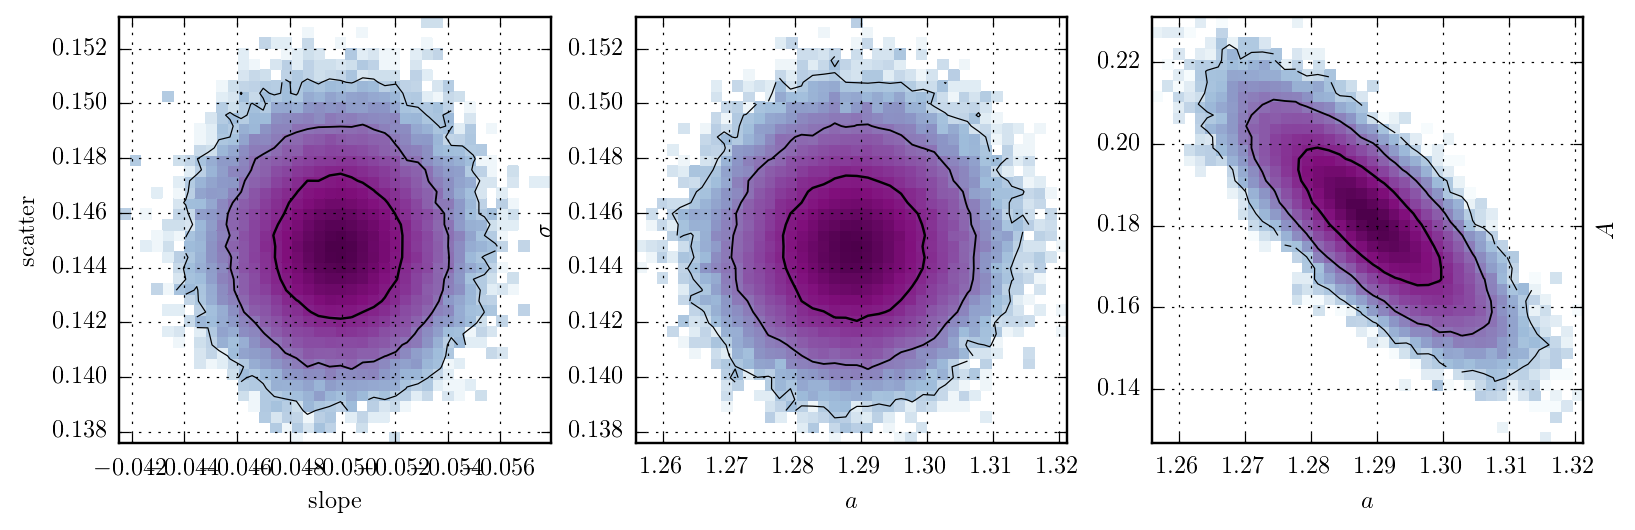

In [23]:
mlim = [np.min(m), np.max(m)]
c0lim = [np.min(c0), np.max(c0)]
c1lim = [np.min(c1), np.max(c1)]
slim = [np.min(s), np.max(s)]
clevs = (0.683, 0.955, 0.997) #np.linspace(0.2,0.95,4)

# let's plot 2d posterios of the parameters
fig, ax = plt.subplots(1,3,figsize=(9.,3.))
plt.tight_layout(); plt.rc('font',size=10)

plot_2d_dist(m, s, xlim=mlim, ylim=slim, nxbins=41, nybins=41, clevs=clevs, 
             xlabel=r'$\mathrm{slope}$', ylabel=r'$\mathrm{scatter}$',  fig_setup=ax[0])
ax[0].grid()
plot_2d_dist(c0, s, xlim=c0lim, ylim=slim, nxbins=41, nybins=41, clevs=clevs, 
             xlabel=r'$a$', ylabel=r'$\sigma$',  fig_setup=ax[1])
ax[1].grid()
plot_2d_dist(c0, c1, xlim=c0lim, ylim=c1lim, nxbins=41, nybins=41, clevs=clevs, 
             xlabel=r'$a$', ylabel=r'$A$',  fig_setup=ax[2])
ax[2].grid()
ax[2].yaxis.set_label_position('right')
plt.show()
    


Now let's compare results to Phil's old fit visually. 

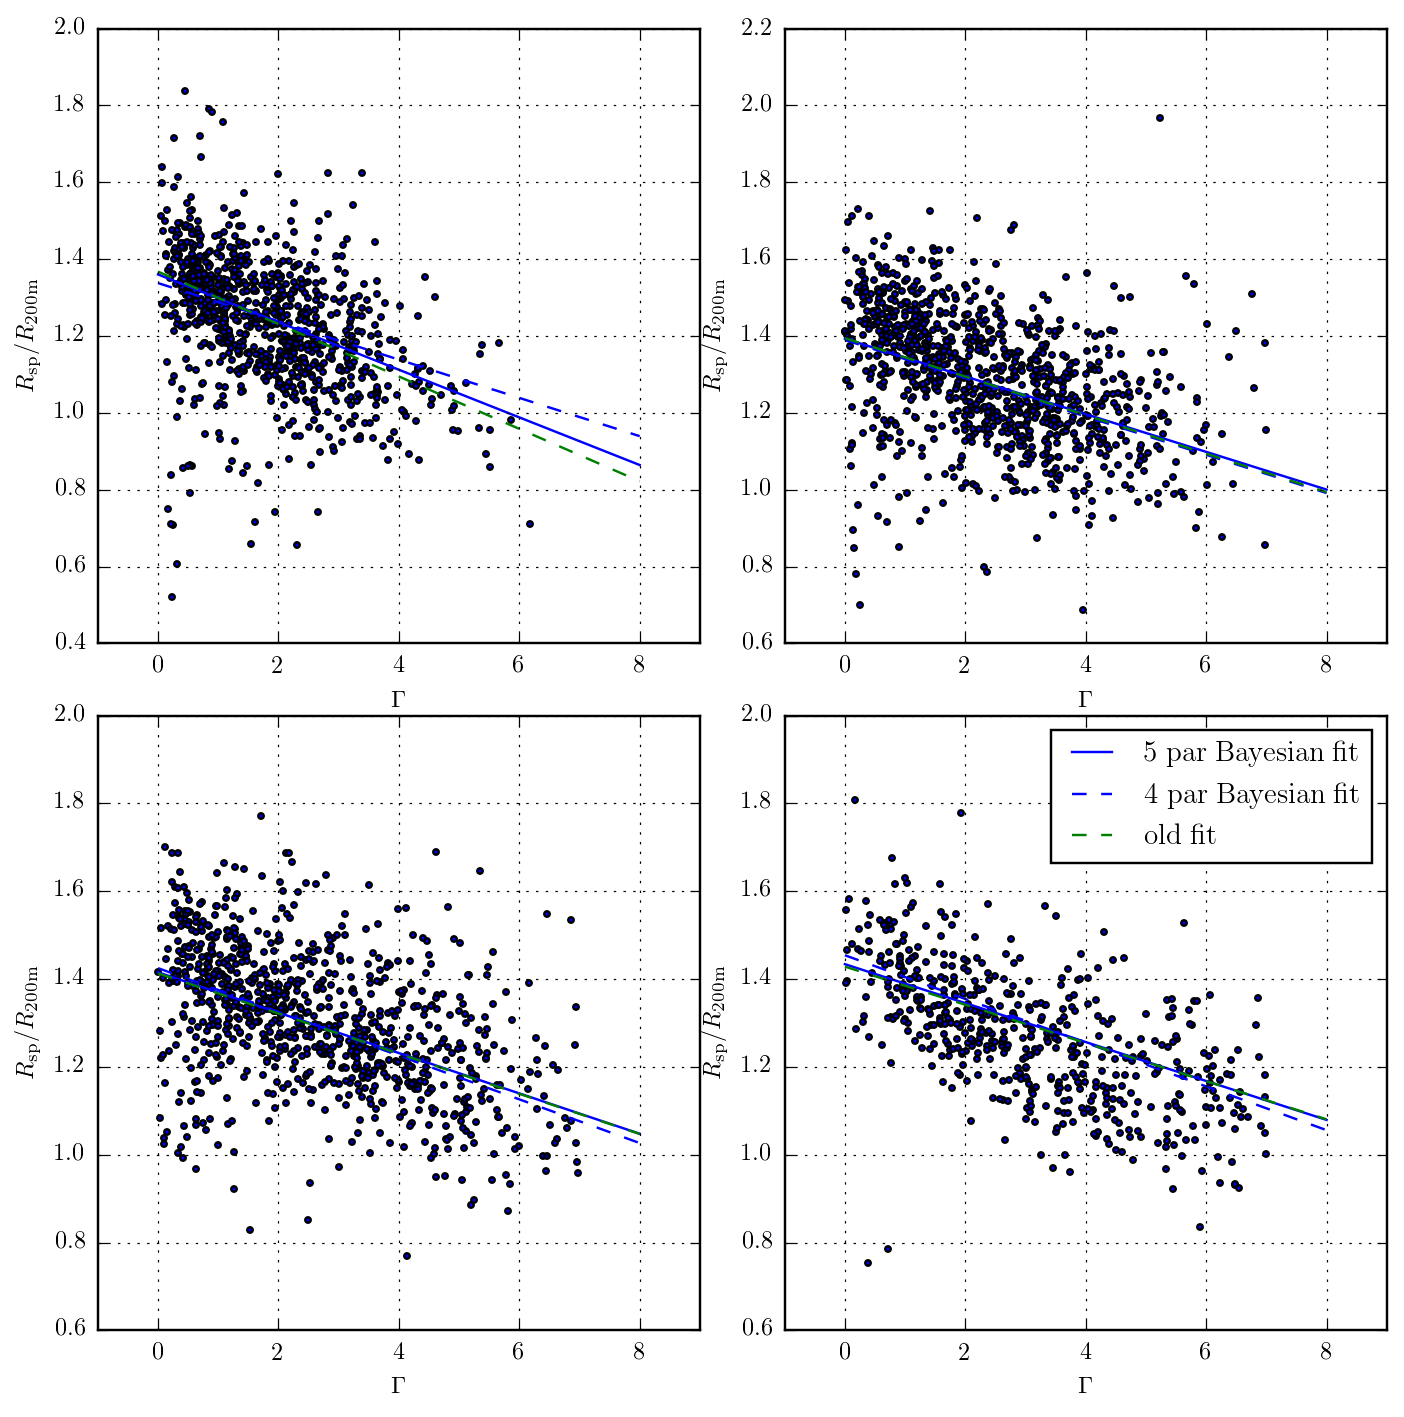

In [43]:
iz00 = (zout==0.0); y00 = Rsp[iz00]/R200m[iz00]; x00 = G200[iz00]
iz05 = (zout==0.5); y05 = Rsp[iz05]/R200m[iz05]; x05 = G200[iz05]
iz10 = (zout==1.0); y10 = Rsp[iz10]/R200m[iz10]; x10 = G200[iz10]
iz20 = (zout==2.0); y20 = Rsp[iz20]/R200m[iz20]; x20 = G200[iz20]

x = np.linspace(0.,8.,100)

yf00 = c0_lmax + c1_lmax*cosmo.Om(z=0.0) + (m0_lmax + m1_lmax/cosmo.Om(z=0.0))*x
yf05 = c0_lmax + c1_lmax*cosmo.Om(z=0.5) + (m0_lmax + m1_lmax/cosmo.Om(z=0.5))*x
yf10 = c0_lmax + c1_lmax*cosmo.Om(z=1.0) + (m0_lmax + m1_lmax/cosmo.Om(z=1.0))*x
yf20 = c0_lmax + c1_lmax*cosmo.Om(z=2.0) + (m0_lmax + m1_lmax/cosmo.Om(z=2.0))*x

yf00_2 = c0_lmax2 + c1_lmax2*cosmo.Om(z=0.0) + m_lmax2*x
yf05_2 = c0_lmax2 + c1_lmax2*cosmo.Om(z=0.5) + m_lmax2*x
yf10_2 = c0_lmax2 + c1_lmax2*cosmo.Om(z=1.0) + m_lmax2*x
yf20_2 = c0_lmax2 + c1_lmax2*cosmo.Om(z=2.0) + m_lmax2*x

ayp_phil = 1.342; c_med_phil= 0.095; m_med_phil = -0.0095
yf00_phil = ayp_phil + c_med_phil*cosmo.Om(z=0.0) + (-0.033 + m_med_phil/cosmo.Om(z=0.0))*x
yf05_phil = ayp_phil + c_med_phil*cosmo.Om(z=0.5) + (-0.033 + m_med_phil/cosmo.Om(z=0.5))*x
yf10_phil = ayp_phil + c_med_phil*cosmo.Om(z=1.0) + (-0.033 + m_med_phil/cosmo.Om(z=1.0))*x
yf20_phil = ayp_phil + c_med_phil*cosmo.Om(z=2.0) + (-0.033 + m_med_phil/cosmo.Om(z=2.0))*x

fig, ax = plt.subplots(2,2,figsize=(8.,8.))
plt.tight_layout(); plt.rc('font',size=10)
# z= 0.0
ax[0][0].set_xlabel(r'$\Gamma$'); ax[0][0].set_ylabel(r'$R_{\rm sp}/R_{\rm 200m}$')
ax[0][0].scatter(x00,y00,marker='.')
ax[0][0].plot(x,yf00, c='b')
ax[0][0].plot(x,yf00_2, '--', c='b')
ax[0][0].plot(x,yf00_phil,'--', c='g')
ax[0][0].grid()
# z = 0.5
ax[0][1].set_xlabel(r'$\Gamma$'); ax[0][1].set_ylabel(r'$R_{\rm sp}/R_{\rm 200m}$')
ax[0][1].scatter(x05,y05,marker='.')
ax[0][1].plot(x,yf05, c='b')
ax[0][1].plot(x,yf05_2, '--', c='b')
ax[0][1].plot(x,yf05_phil,'--', c='g')
ax[0][1].grid()
# z = 1.0
ax[1][0].set_xlabel(r'$\Gamma$'); ax[1][0].set_ylabel(r'$R_{\rm sp}/R_{\rm 200m}$')
ax[1][0].scatter(x10,y10,marker='.')
ax[1][0].plot(x,yf10, c='b')
ax[1][0].plot(x,yf10_2, '--', c='b')
ax[1][0].plot(x,yf10_phil,'--', c='g')
ax[1][0].grid()
# z = 2.0
ax[1][1].set_xlabel(r'$\Gamma$'); ax[1][1].set_ylabel(r'$R_{\rm sp}/R_{\rm 200m}$')
ax[1][1].scatter(x20,y20,marker='.')
ax[1][1].plot(x,yf20, c='b', label=r'$\mathrm{5\ par\ Bayesian\ fit}$')
ax[1][1].plot(x,yf20_2, '--', c='b', label=r'$\mathrm{4\ par\ Bayesian\ fit}$')
ax[1][1].plot(x,yf20_phil,'--', c='g', label=r'$\mathrm{old\ fit}$')
ax[1][1].grid()
plt.legend()
plt.show()


### Exponential fit

Finally, let's fit the More et al. functional form to see how much curvature in the relation data wants. 

In [25]:
def line_fit_vert_like3 (x, params=None): 
    """
    likelihood for an exponential model a la More et al. (2015) for data with error bars in both directions 
    and intrinsic scatter in y direction
    the merit function is also in y-direction 
    input: x - vector of parameters: 
           params = [x, y, z, c00, c01, c11]            
    """
    p = params; nw = np.shape(x)[0]; res = np.zeros(nw) 
    Omd = cosmo.Om(p[2])
    for i in range(nw):
        dummy = x[i,4] + p[5] # ignore x errors, which are considered negligible here
        yf = (x[i,0] + x[i,1]*Omd)*(1.0 + x[i,2]*np.exp(-x[i,3]*p[0])) 
        res[i] = -0.5*(np.sum(np.log(dummy))+np.sum((p[1]-yf)**2/dummy)) + prior(x[i,:])
    return res


In [26]:
# initial values
nwalkers = 200
c0 = 0.75; c1 = 0.11; c2 = 0.73; c3 = 0.11; s2_0 = 0.01; 
ipar_active = np.array([1, 1, 1, 1, 1])

chain3, Rval3, nthin3 = mcmc_fit(xd, yd, zout, ex, ey, pini=[c0, c1, c2, c3, s2_0], 
                              ipar_active=ipar_active, nwalkers=nwalkers, 
                              modelpdf=line_fit_vert_like3, Rlim=1.04)



starting sampling with 5 active parameters of the total 5 parameters
nchain= 1000
R values for parameters: [ 1.1733452   1.11459017  1.15213788  1.13917376  1.00562706]
tcorr = 16.2431855236
nchain= 2000
R values for parameters: [ 1.08872697  1.06258266  1.08717157  1.07429469  1.00419667]
tcorr = 65.0096911391
nchain= 3000
R values for parameters: [ 1.06232751  1.04652807  1.06537374  1.05131079  1.00421564]
tcorr = 63.2830464818
nchain= 4000
R values for parameters: [ 1.0471967   1.03658965  1.05052344  1.03916634  1.00398346]
tcorr = 61.8911741635
nchain= 5000
R values for parameters: [ 1.03701843  1.02858619  1.04030412  1.03016694  1.00353192]
tcorr = 61.0479682764
nchain= 6000
R values for parameters: [ 1.03480838  1.02628213  1.03778661  1.02853111  1.0031299 ]
tcorr = 60.386550247
MCMC sampler generated  1200000  samples using 200  walkers
with step acceptance ratio of 0.376896666667


In [27]:
nburn3 = int(20*nwalkers*nthin3)

chain3 = chain3[nburn3:]
nchain3 = np.shape(chain3)[0]
nran3 = nchain3/10
iran3 = np.random.randint(0,nchain3,nran3)
chain3r = np.array(chain3)[iran3,:]


c0 = chain3r[:,0]; c1 = chain3r[:,1]; c2 = chain3r[:,2]; c3 = chain3r[:,3]; s3 = chain3r[:,4]


In [28]:
c00 = ex*ex; c01 = 0.0; c11 = ey*ey
params = [xd, yd, zout, c00, c01, c11]

xch = np.zeros([np.size(s3),5])
xch[:,0] = c0; xch[:,1] = c1; xch[:,2] = c2; xch[:,3] = c3; xch[:,4] = s3
loglikevals3 = line_fit_vert_like3(xch, params)
s3 = np.sqrt(s3)

imaxlike3 = np.argmax(loglikevals3)
print imaxlike3, np.size(loglikevals3)

48160 96000


In [29]:

print "============ best parameters of the fit with slope independent of z =================="
print "best fit parameter 1:"
c0_lmax3, c0_med3, c0_mean3, c0_std3, c0_68m3, c0_68p3, c0_95m3, c0_95p3 = pstats(c0, imaxlike3)
print "best fit parameter 2:"
c1_lmax3, c1_med3, c1_mean3, c1_std3, c1_68m3, c1_68p3, c1_95m3, c1_95p3 = pstats(c1, imaxlike3)
print "best fit parameter 3:"
c2_lmax3, c2_med3, c2_mean3, c2_std3, c2_68m3, c2_68p3, c2_95m3, c2_95p3 = pstats(c2, imaxlike3)
print "best fit parameter 4:"
c3_lmax3, c3_med3, c3_mean3, c3_std3, c3_68m3, c3_68p3, c3_95m3, c3_95p3 = pstats(c3, imaxlike3)
print "best fit scatter:",
s_lmax3, s_med3, s_mean3, s_std3, s_68m3, s_68p3, s_95m3, s_95p3 = pstats(s3, imaxlike3)

bic3 = -2.*loglikevals3[imaxlike3] + 5.*np.log(np.size(xd))
print "BIC factor of the fit = %.3e"%bic3


============ best parameters of the fit with slope independent of z ==================
best fit parameter 1:
max. likelihood, mean, median = 0.7443 0.7560, 0.7600, st.dev=0.0684
68perc interval = 0.683, 0.826
95perc interval = 0.620, 0.879
 
best fit parameter 2:
max. likelihood, mean, median = 0.1131 0.1148, 0.1149, st.dev=0.0119
68perc interval = 0.103, 0.126
95perc interval = 0.092, 0.138
 
best fit parameter 3:
max. likelihood, mean, median = 0.7426 0.7309, 0.7084, st.dev=0.1577
68perc interval = 0.575, 0.896
95perc interval = 0.482, 1.083
 
best fit parameter 4:
max. likelihood, mean, median = 0.1130 0.1195, 0.1174, st.dev=0.0215
68perc interval = 0.098, 0.141
95perc interval = 0.086, 0.167
 
best fit scatter: max. likelihood, mean, median = 0.1445 0.1446, 0.1446, st.dev=0.0016
68perc interval = 0.143, 0.146
95perc interval = 0.141, 0.148
 
BIC factor of the fit = -9.552e+03


In [30]:
bf3, ebf3 = estimate_bayes_factor(xch, loglikevals3, r=0.05)

print "Bayes factor=:", bf3, ebf3 

Bayes factor=: 4783.42654446 1.30294090526


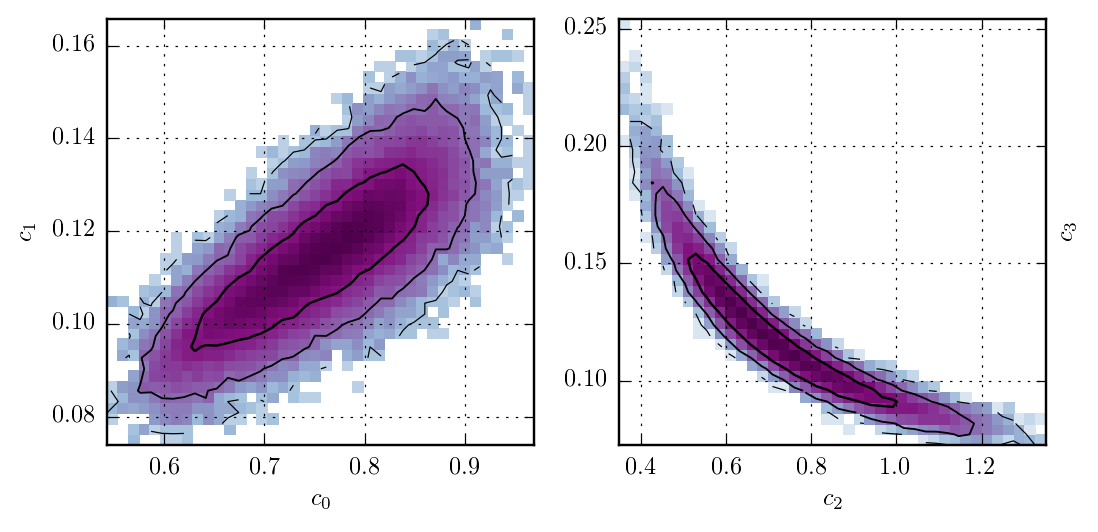

In [31]:
c0lim = [np.min(c0), np.max(c0)]
c1lim = [np.min(c1), np.max(c1)]
c2lim = [np.min(c2), np.max(c2)]
c3lim = [np.min(c3), np.max(c3)]

slim = [np.min(s3), np.max(s3)]
clevs = (0.683, 0.955, 0.997) 

# let's plot 2d posteriors of the parameters
fig, ax = plt.subplots(1,2,figsize=(6.,3.))
plt.tight_layout(); plt.rc('font',size=10)

plot_2d_dist(c0, c1, xlim=c0lim, ylim=c1lim, nxbins=41, nybins=41, clevs=clevs, 
             xlabel=r'$c_0$', ylabel=r'$c_1$',  fig_setup=ax[0])
ax[0].grid()
plot_2d_dist(c2, c3, xlim=c2lim, ylim=c3lim, nxbins=41, nybins=41, clevs=clevs, 
             xlabel=r'$c_2$', ylabel=r'$c_3$',  fig_setup=ax[1])
ax[1].grid()
ax[1].yaxis.set_label_position('right')
plt.show()
    

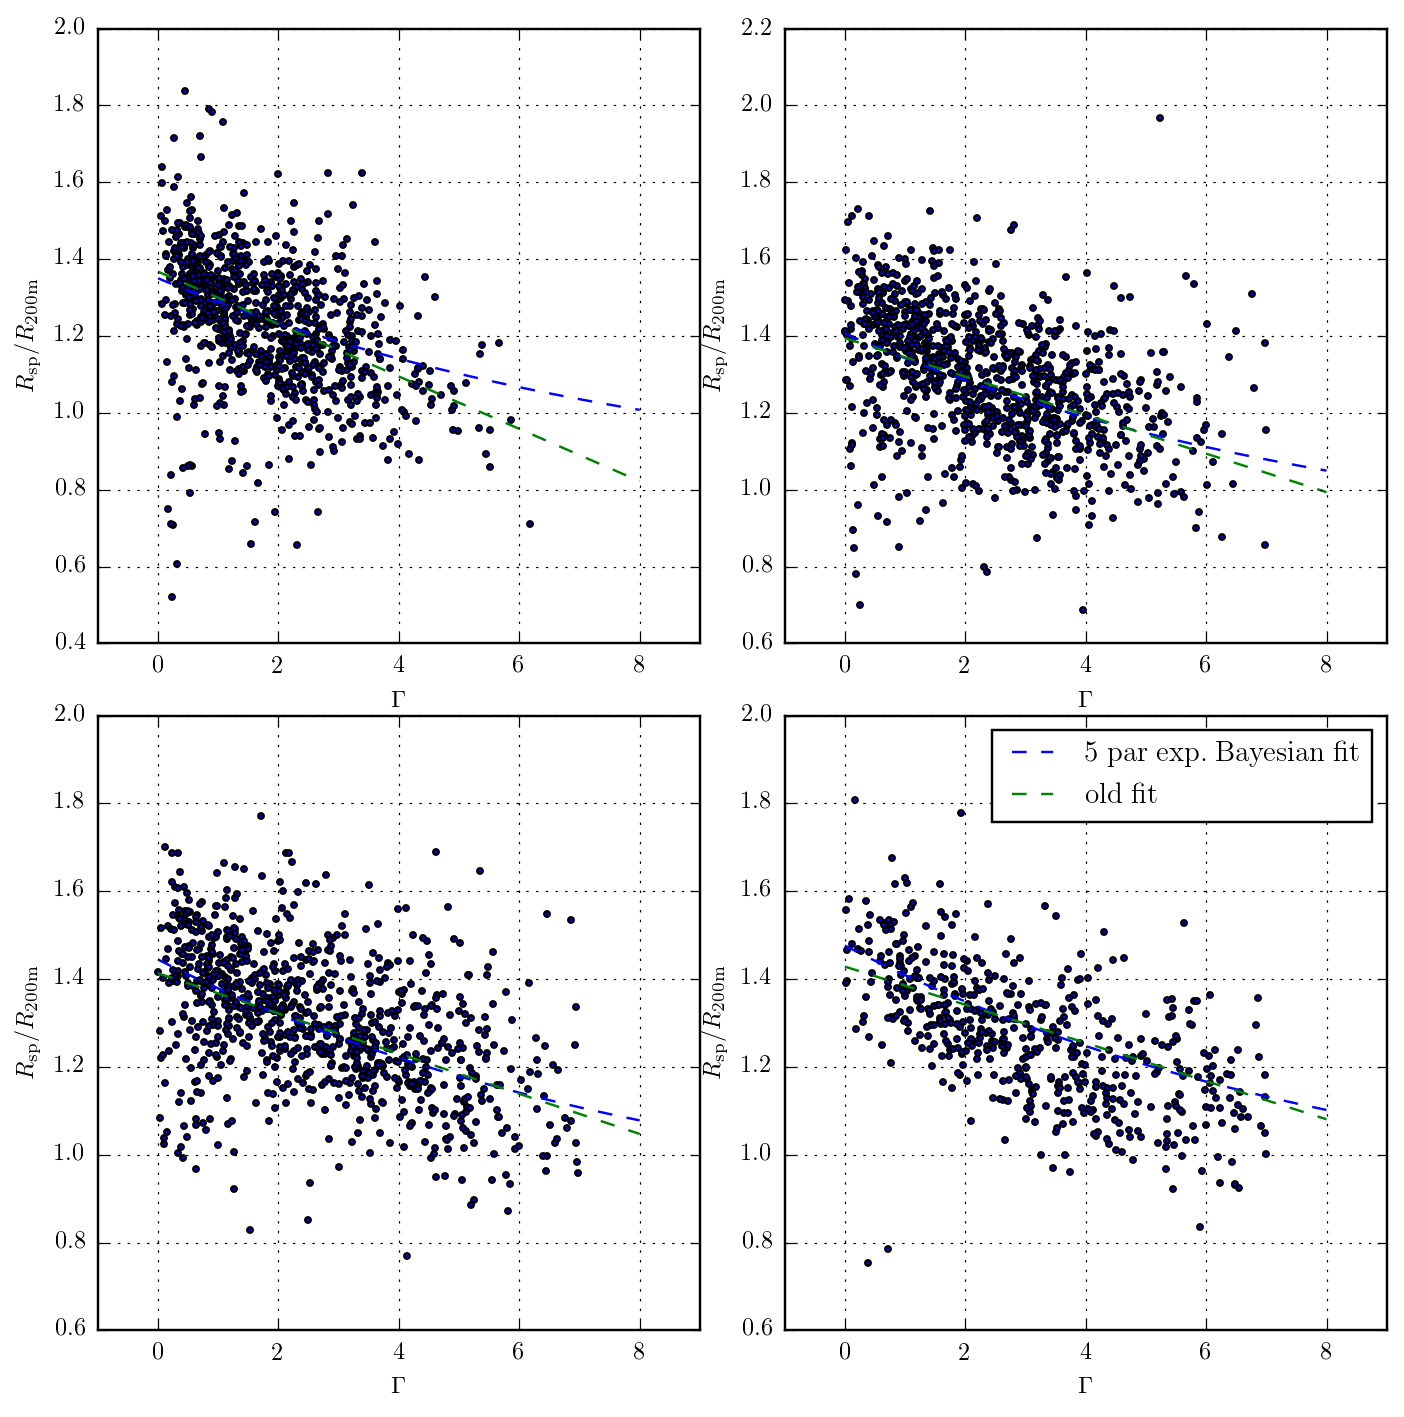

In [32]:
iz00 = (zout==0.0); y00 = Rsp[iz00]/R200m[iz00]; x00 = G200[iz00]
iz05 = (zout==0.5); y05 = Rsp[iz05]/R200m[iz05]; x05 = G200[iz05]
iz10 = (zout==1.0); y10 = Rsp[iz10]/R200m[iz10]; x10 = G200[iz10]
iz20 = (zout==2.0); y20 = Rsp[iz20]/R200m[iz20]; x20 = G200[iz20]

x = np.linspace(0.,8.,100)


yf00_3 = (c0_lmax3 + c1_lmax3*cosmo.Om(z=0.0))*(1. + c2_lmax3*np.exp(-c3_lmax3*x))
yf05_3 = (c0_lmax3 + c1_lmax3*cosmo.Om(z=0.5))*(1. + c2_lmax3*np.exp(-c3_lmax3*x))
yf10_3 = (c0_lmax3 + c1_lmax3*cosmo.Om(z=1.0))*(1. + c2_lmax3*np.exp(-c3_lmax3*x))
yf20_3 = (c0_lmax3 + c1_lmax3*cosmo.Om(z=2.0))*(1. + c2_lmax3*np.exp(-c3_lmax3*x))

ayp_phil = 1.342; c_med_phil= 0.095; m_med_phil = -0.0095
yf00_phil = ayp_phil + c_med_phil*cosmo.Om(z=0.0) + (-0.033 + m_med_phil/cosmo.Om(z=0.0))*x
yf05_phil = ayp_phil + c_med_phil*cosmo.Om(z=0.5) + (-0.033 + m_med_phil/cosmo.Om(z=0.5))*x
yf10_phil = ayp_phil + c_med_phil*cosmo.Om(z=1.0) + (-0.033 + m_med_phil/cosmo.Om(z=1.0))*x
yf20_phil = ayp_phil + c_med_phil*cosmo.Om(z=2.0) + (-0.033 + m_med_phil/cosmo.Om(z=2.0))*x

fig, ax = plt.subplots(2,2,figsize=(8.,8.))
plt.tight_layout(); plt.rc('font',size=10)
# z= 0.0
ax[0][0].set_xlabel(r'$\Gamma$'); ax[0][0].set_ylabel(r'$R_{\rm sp}/R_{\rm 200m}$')
ax[0][0].scatter(x00,y00,marker='.')
ax[0][0].plot(x,yf00_3, '--', c='b')
ax[0][0].plot(x,yf00_phil,'--', c='g')
ax[0][0].grid()
# z = 0.5
ax[0][1].set_xlabel(r'$\Gamma$'); ax[0][1].set_ylabel(r'$R_{\rm sp}/R_{\rm 200m}$')
ax[0][1].scatter(x05,y05,marker='.')
ax[0][1].plot(x,yf05_3, '--', c='b')
ax[0][1].plot(x,yf05_phil,'--', c='g')
ax[0][1].grid()
# z = 1.0
ax[1][0].set_xlabel(r'$\Gamma$'); ax[1][0].set_ylabel(r'$R_{\rm sp}/R_{\rm 200m}$')
ax[1][0].scatter(x10,y10,marker='.')
ax[1][0].plot(x,yf10_3, '--', c='b')
ax[1][0].plot(x,yf10_phil,'--', c='g')
ax[1][0].grid()
# z = 2.0
ax[1][1].set_xlabel(r'$\Gamma$'); ax[1][1].set_ylabel(r'$R_{\rm sp}/R_{\rm 200m}$')
ax[1][1].scatter(x20,y20,marker='.')
ax[1][1].plot(x,yf20_3, '--', c='b', label=r'$\mathrm{5\ par\ exp.\ Bayesian\ fit}$')
ax[1][1].plot(x,yf20_phil,'--', c='g', label=r'$\mathrm{old\ fit}$')
ax[1][1].grid()
plt.legend()
plt.show()


Overall, the fits do not generate much curvature, so line fits are ok. Visually, it looks like at $z=1,2$ there is some curvature and exponential could be a better fit, but low $z$ data do not allow for much curvature.

Try making the factor in the exponent redshift dependent.

In [33]:
def line_fit_vert_like4 (x, params=None): 
    """
    likelihood for an exponential model a la More et al. (2015) for data with error bars in both directions 
    and intrinsic scatter in y direction
    the merit function is also in y-direction 
    input: x - vector of parameters: 
           params = [x, y, z, c00, c01, c11]            
    """
    p = params; nw = np.shape(x)[0]; res = np.zeros(nw) 
    Omd = cosmo.Om(p[2])
    for i in range(nw):
        dummy = x[i,4] + p[5] # ignore x errors, which are considered negligible here
        yf = (x[i,0] + x[i,1]*Omd)*(1.0 + x[i,2]*np.exp(-x[i,3]*Omd*p[0])) 
        res[i] = -0.5*(np.sum(np.log(dummy)) + np.sum((p[1]-yf)**2/dummy)) + prior(x[i,:])
    return res


In [34]:
# initial values
nwalkers = 200
c0 = 0.78; c1 = 0.25; c2 = 0.47; c3 = 0.26; s2_0 = 0.145**2; 
ipar_active = np.array([1, 1, 1, 1, 1])

chain4, Rval4, nthin4 = mcmc_fit(xd, yd, zout, ex, ey, pini=[c0, c1, c2, c3, s2_0], 
                              ipar_active=ipar_active, nwalkers=nwalkers, 
                              modelpdf=line_fit_vert_like4, Rlim=1.04)



starting sampling with 5 active parameters of the total 5 parameters
nchain= 1000
R values for parameters: [ 1.1514471   1.06515675  1.05379987  1.04438996  0.94576568]
tcorr = 25.5627041648
nchain= 2000
R values for parameters: [ 1.03286917  1.02561717  1.02394528  1.02188948  1.11092034]
tcorr = 34.2461918598
nchain= 3000
R values for parameters: [ 1.01983195  1.01798528  1.01670063  1.01500923  1.02709856]
tcorr = 18.0103698494
MCMC sampler generated  600000  samples using 200  walkers
with step acceptance ratio of 0.454741666667


In [35]:
nburn4 = int(20*nwalkers*nthin4)

chain4 = chain4[nburn4:]
nchain4 = np.shape(chain4)[0]
nran4 = nchain4/nthin4
iran4 = np.random.randint(0,nchain4,nran4)
chain4r = np.array(chain4)[iran4,:]

c0 = chain4r[:,0]; c1 = chain4r[:,1]; c2 = chain4r[:,2]; c3 = chain4r[:,3]; s3 = chain4r[:,4]


In [36]:
c00 = ex*ex; c01 = 0.0; c11 = ey*ey
params = [xd, yd, zout, c00, c01, c11]

xch = np.zeros([np.size(s3),5])
xch[:,0] = c0; xch[:,1] = c1; xch[:,2] = c2; xch[:,3] = c3; xch[:,4] = s3
s3 = np.sqrt(s3)
loglikevals4 = line_fit_vert_like4(xch, params)

imaxlike4 = np.argmax(loglikevals4)
print imaxlike4, np.size(loglikevals4), loglikevals4[imaxlike4]

28351 29333 4761.39728326


In [37]:

print "============ best parameters of the 2nd version of the exp. fit =================="
print "best fit parameter 1:"
c0_lmax4, c0_med4, c0_mean4, c0_std4, c0_68m4, c0_68p4, c0_95m4, c0_95p4 = pstats(c0, imaxlike4)
print "best fit parameter 2:"
c1_lmax4, c1_med4, c1_mean4, c1_std4, c1_68m4, c1_68p4, c1_95m4, c1_95p4 = pstats(c1, imaxlike4)
print "best fit parameter 3:"
c2_lmax4, c2_med4, c2_mean4, c2_std4, c2_68m4, c2_68p4, c2_95m4, c2_95p4 = pstats(c2, imaxlike4)
print "best fit parameter 4:"
c3_lmax4, c3_med4, c3_mean4, c3_std4, c3_68m4, c3_68p4, c3_95m4, c3_95p4 = pstats(c3, imaxlike4)
print "best fit scatter:",
s_lmax4, s_med4, s_mean4, s_std4, s_68m4, s_68p4, s_95m4, s_95p4 = pstats(s3, imaxlike4)

bic4 = -2.*loglikevals4[imaxlike4] + 5.*np.log(np.size(xd))
print "BIC factor of the fit = %.3e"%bic4


============ best parameters of the 2nd version of the exp. fit ==================
best fit parameter 1:
max. likelihood, mean, median = 0.8141 0.8116, 0.8131, st.dev=0.0314
68perc interval = 0.782, 0.842
95perc interval = 0.744, 0.869
 
best fit parameter 2:
max. likelihood, mean, median = 0.2492 0.2500, 0.2503, st.dev=0.0135
68perc interval = 0.237, 0.263
95perc interval = 0.222, 0.276
 
best fit parameter 3:
max. likelihood, mean, median = 0.4675 0.4735, 0.4690, st.dev=0.0543
68perc interval = 0.422, 0.523
95perc interval = 0.382, 0.596
 
best fit parameter 4:
max. likelihood, mean, median = 0.2599 0.2640, 0.2626, st.dev=0.0359
68perc interval = 0.229, 0.299
95perc interval = 0.197, 0.340
 
best fit scatter: max. likelihood, mean, median = 0.1459 0.1461, 0.1461, st.dev=0.0017
68perc interval = 0.145, 0.148
95perc interval = 0.143, 0.150
 
BIC factor of the fit = -9.482e+03


In [38]:
bf4, ebf4 = estimate_bayes_factor(xch, loglikevals4, r=0.05)

print "Bayes factor=:", bf4, ebf4 

Bayes factor=: 4747.55370503 1.262616234


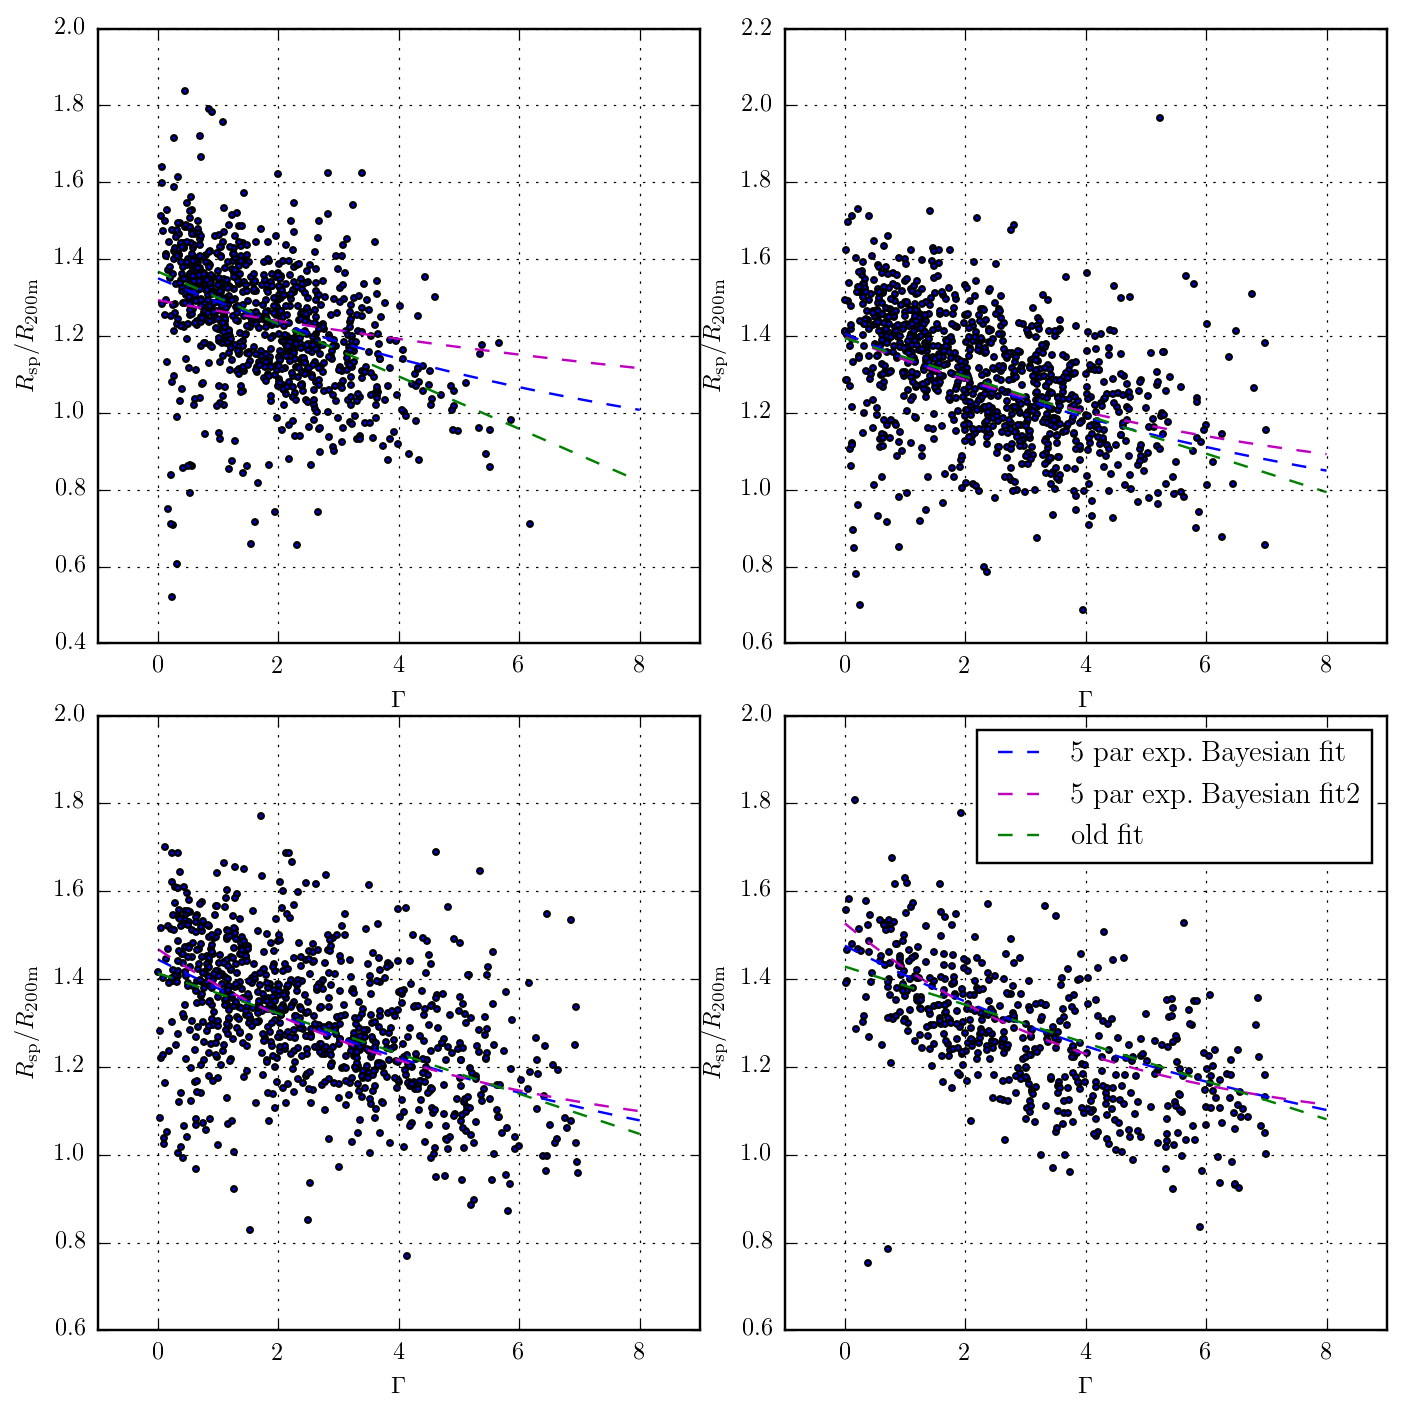

In [39]:
iz00 = (zout==0.0); y00 = Rsp[iz00]/R200m[iz00]; x00 = G200[iz00]
iz05 = (zout==0.5); y05 = Rsp[iz05]/R200m[iz05]; x05 = G200[iz05]
iz10 = (zout==1.0); y10 = Rsp[iz10]/R200m[iz10]; x10 = G200[iz10]
iz20 = (zout==2.0); y20 = Rsp[iz20]/R200m[iz20]; x20 = G200[iz20]

x = np.linspace(0.,8.,100)

yf00_3 = (c0_lmax3 + c1_lmax3*cosmo.Om(z=0.0))*(1. + c2_lmax3*np.exp(-c3_lmax3*x))
yf05_3 = (c0_lmax3 + c1_lmax3*cosmo.Om(z=0.5))*(1. + c2_lmax3*np.exp(-c3_lmax3*x))
yf10_3 = (c0_lmax3 + c1_lmax3*cosmo.Om(z=1.0))*(1. + c2_lmax3*np.exp(-c3_lmax3*x))
yf20_3 = (c0_lmax3 + c1_lmax3*cosmo.Om(z=2.0))*(1. + c2_lmax3*np.exp(-c3_lmax3*x))

yf00_4 = (c0_lmax4 + c1_lmax4*cosmo.Om(z=0.0))*(1. + c2_lmax4*np.exp(-cosmo.Om(z=0.0)*c3_lmax4*x))
yf05_4 = (c0_lmax4 + c1_lmax4*cosmo.Om(z=0.5))*(1. + c2_lmax4*np.exp(-cosmo.Om(z=0.5)*c3_lmax4*x))
yf10_4 = (c0_lmax4 + c1_lmax4*cosmo.Om(z=1.0))*(1. + c2_lmax4*np.exp(-cosmo.Om(z=1.0)*c3_lmax4*x))
yf20_4 = (c0_lmax4 + c1_lmax4*cosmo.Om(z=2.0))*(1. + c2_lmax4*np.exp(-cosmo.Om(z=2.0)*c3_lmax4*x))

ayp_phil = 1.342; c_med_phil= 0.095; m_med_phil = -0.0095
yf00_phil = ayp_phil + c_med_phil*cosmo.Om(z=0.0) + (-0.033 + m_med_phil/cosmo.Om(z=0.0))*x
yf05_phil = ayp_phil + c_med_phil*cosmo.Om(z=0.5) + (-0.033 + m_med_phil/cosmo.Om(z=0.5))*x
yf10_phil = ayp_phil + c_med_phil*cosmo.Om(z=1.0) + (-0.033 + m_med_phil/cosmo.Om(z=1.0))*x
yf20_phil = ayp_phil + c_med_phil*cosmo.Om(z=2.0) + (-0.033 + m_med_phil/cosmo.Om(z=2.0))*x

fig, ax = plt.subplots(2,2,figsize=(8.,8.))
plt.tight_layout(); plt.rc('font',size=10)
# z= 0.0
ax[0][0].set_xlabel(r'$\Gamma$'); ax[0][0].set_ylabel(r'$R_{\rm sp}/R_{\rm 200m}$')
ax[0][0].scatter(x00,y00,marker='.')
ax[0][0].plot(x,yf00_3, '--', c='b')
ax[0][0].plot(x,yf00_4, '--', c='m')
ax[0][0].plot(x,yf00_phil,'--', c='g')
ax[0][0].grid()
# z = 0.5
ax[0][1].set_xlabel(r'$\Gamma$'); ax[0][1].set_ylabel(r'$R_{\rm sp}/R_{\rm 200m}$')
ax[0][1].scatter(x05,y05,marker='.')
ax[0][1].plot(x,yf05_3, '--', c='b')
ax[0][1].plot(x,yf05_4, '--', c='m')
ax[0][1].plot(x,yf05_phil,'--', c='g')
ax[0][1].grid()
# z = 1.0
ax[1][0].set_xlabel(r'$\Gamma$'); ax[1][0].set_ylabel(r'$R_{\rm sp}/R_{\rm 200m}$')
ax[1][0].scatter(x10,y10,marker='.')
ax[1][0].plot(x,yf10_3, '--', c='b')
ax[1][0].plot(x,yf10_4, '--', c='m')
ax[1][0].plot(x,yf10_phil,'--', c='g')
ax[1][0].grid()
# z = 2.0
ax[1][1].set_xlabel(r'$\Gamma$'); ax[1][1].set_ylabel(r'$R_{\rm sp}/R_{\rm 200m}$')
ax[1][1].scatter(x20,y20,marker='.')
ax[1][1].plot(x,yf20_3, '--', c='b', label=r'$\mathrm{5\ par\ exp.\ Bayesian\ fit}$')
ax[1][1].plot(x,yf20_4, '--', c='m', label=r'$\mathrm{5\ par\ exp.\ Bayesian\ fit 2}$')
ax[1][1].plot(x,yf20_phil,'--', c='g', label=r'$\mathrm{old\ fit}$')
ax[1][1].grid()
plt.legend()
plt.show()


### Summary

In [41]:
print "BIC factors summary for the fits (smaller is better):"
print "%.1f %.1f %.1f %.1f"%(bic, bic2, bic3, bic4)

print "Bayes factors summary for the fits (larger is better):"
print "%.1f %.1f %.1f %.1f"%(bf, bf2, bf3, bf4)


BIC factors summary for the fits:
-9570.0 -9550.7 -9552.1 -9482.2
Bayes factors summary for the fits:
4790.2 4779.7 4783.4 4747.6


The original Phil's fit parametrization works fine. One could reduce the number of parameters to 4 by making slope redshift independent without much loss of fit quality. However, there is not much gain either. Exponential fit of More et al. form, does comparably to the linear fits with 4 or 5 parameters, only slightly worse than Phil's linear parametrization. There is not much justification for using it over linear fit. There is some visual curvature in the point distribution at higher z, so it is possible that some nonlinear parametrization would work better than linear. However, the gain in quality is likely to be incremental. 

The main conclusion: stick with the current fit, but update the best fit values and error bars (which were underestimated in Phil's fits). 